# 解析MNIST数据集

参考文章：《使用Python解析MNIST数据集（IDX文件格式）》
https://www.jianshu.com/p/84f72791806f

CSY 2019-12-16

对MNIST手写数字数据文件转换为bmp图片文件格式。
数据集下载地址为http://yann.lecun.com/exdb/mnist

=====================
IDX文件的格式
---------------------

基本格式如下：

------------------
幻数(magic number)  
0维的大小  
1维的大小  
2维的大小  
...  
N维的大小  
数据(data)...
__________________

幻数是最高位有效位在前(MSB firt)的四字节整型数。  

前两个字节为0。  

第三个字节指明了数据(the data)的类型：  
0x08  无符号的字节型 (8bit)  
0x09  有符号的字节型 (8bit)  
0x0B  短整型 (16bit)  
0x0C  整型 (32bit)  
0x0D  浮点型 (32bit)  
0x0E  双精度浮点型 (64bit)

第四个字节指明向量或矩阵的维度：  
1  向量  
2  矩阵  
...  
________________________________________________


每一个维度的大小都用4字节的整型数表示。最高有效位在前（MSB first）、大端(high endian)。

____________________________________________

数据(the data)向C语言中的数组一样存储。例如，最后一维的变化最快。


第1句 用于 Linux/Unix ，指定调用  /usr/bin 下的 python 解释器。  
建议用 #!/usr/bin/env python 代替。  
使用 python a.py 忽略该行。
第2句 告诉python解释器，源程序用utf-8编码

In [1]:
#!/usr/bin/python 
#_*_ coding: utf-8 _*_

In [17]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import random

在办公室的机器上运行的程序段

In [ ]:
# 训练集图像文件
#train_images_file = '../train-images.idx3-ubyte'
train_images_file = 'train-images.idx3-ubyte'
# 训练集标签文件
#train_labels_file = '../train-labels.idx1-ubyte'
train_labels_file = 'train-labels.idx1-ubyte'
# 测试集图像文件
#test_images_file = '../t10k-images.idx3-ubyte'
test_images_file = 't10k-images.idx3-ubyte'
# 测试集标签文件
#test_labels_file = '../t10k-labels.idx1-ubyte'
test_labels_file = 't10k-labels.idx1-ubyte'

在联想笔记本上运行的程序段

In [18]:
# 训练集图像文件
train_images_file = '../train-images.idx3-ubyte'
#train_images_file = 'train-images.idx3-ubyte'
# 训练集标签文件
train_labels_file = '../train-labels.idx1-ubyte'
#train_labels_file = 'train-labels.idx1-ubyte'
# 测试集图像文件
test_images_file = '../t10k-images.idx3-ubyte'
#test_images_file = 't10k-images.idx3-ubyte'
# 测试集标签文件
test_labels_file = '../t10k-labels.idx1-ubyte'
#test_labels_file = 't10k-labels.idx1-ubyte'

文件操作

open(name[,mode[,buffering]])

参数说明：

name : 一个包含了你要访问的文件名称的字符串值。

mode : mode 决定了打开文件的模式：只读，写入，追加等。所有可取值见如下的完全列表。这个参数是非强制的，默认文件访问模式为只读(r)。

buffering : 如果 buffering 的值被设为 0，就不会有寄存。如果 buffering 的值取 1，访问文件时会寄存行。如果将 buffering 的值设为大于 1 的整数，表明了这就是的寄存区的缓冲大小。如果取负值，寄存区的缓冲大小则为系统默认。

file.read([size])：size 未指定则返回整个文件，如果文件大小 >2 倍内存则有问题，f.read()读到文件尾时返回""(空字串)。

参见：《Python open() 函数》
https://www.runoob.com/python/python-func-open.html

struct

参见：《struct》https://www.liaoxuefeng.com/wiki/1016959663602400/1017685387246080

《Python: struct.pack_into 和 struct.unpack_from 函数学习》https://blog.csdn.net/yourenshuo/article/details/84897404

In [19]:
def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    
    TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black). 
    
    TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read() # 以二进制格式打开，用于只读。返回整个文件
    
    # 取得幻数值，按四字节十六进制存储
    magic_number =''
    for s in bin_data[:4]:       # 此处s为整型数
        s=struct.pack('B',s)     # s转换为字节型
        magic_number += s.hex()  # 四个字节合成字符串
    #print(magic_number)

    # 解析文件头信息，依次为图片数量、每张图片高、每张图片宽，按十进制存储
    offset = 4    # 除去四个字节的幻数，从维度大小开始。
    fmt_header = '>iii' # 3个维度的大小都是4字节整型
    # 按照 fmt_header 指定的格式，从偏移位置 offset 开始，对 bin_data 解包
    num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print ('幻数:0x%s, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols))
 
    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header) # 除去文件头，从数据处开始
    #fmt_image = '>' + str(image_size) + 'B' # 每幅图像的数据格式均为：28*28个字节
    fmt_image = str(image_size) + 'B' # 每幅图像的数据格式均为：28*28个字节
    images = np.empty((num_images, num_rows, num_cols)) # 3维空矩阵（60000,28,28）
    '''
    images的格式为如下形式：
    [[[a000000000,a000000001,a000000002 ... a000000027], #图片1的第1行数据
      [a000000100,a000000101,a000000102 ... a000000127], #图片1的第2行数据
      ...
      [a000002700,a000002701,a000002702 ... a000002727]],#图片1的最后一行数据
      
     [[a000010000,a000010001,a000010002 ... a000010027], #图片2的第1行数据
      [a000010100,a000010101,a000010102 ... a000010127], #图片2的第2行数据
      ...
      [a000012700,a000012701,a000012702 ... a000012727]],#图片2的最后一行数据
     ...
     [[a599990000,a599990001,a599990002 ... a599990027], #图片60000的第1行数据
      [a599990100,a599990101,a599990102 ... a599990127], #图片60000的第2行数据
      ...
      [a599992700,a599992701,a599992702 ... a599992727]]]#图片60000的最后一行数据
    '''
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
        if (i + 1) % 10000 == 0:
            print('已解析 %d' % (i + 1) + '张')
    return images
 

In [7]:
def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    
    TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    
    TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 取得幻数值，按四字节十六进制存储
    magic_number =''
    for s in bin_data[:4]:       # 此处s为整型数
        s=struct.pack('B',s)     # s转换为字节型
        magic_number += s.hex()  # 四个字节合成字符串
    #print(magic_number)

    # 解析文件头信息--标签数量
    offset = 4    # 除去四个字节的幻数，从维度大小开始。
    fmt_header = '>i'
    # 按照 fmt_header 指定的格式，从偏移位置 offset 开始，对 bin_data 解包
    num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print('幻数:0x%s, 图片数量: %d张' % (magic_number, num_images[0]))
    # 解析数据集
    offset += struct.calcsize(fmt_header) # 除去文件头，从数据处开始
    fmt_image = 'B'
    labels = np.empty(num_images)
    for i in range(num_images[0]):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
        if (i + 1) % 10000 == 0:
            print('已解析 %d' % (i + 1) + '张')
    return labels

In [20]:
def load_train_images(idx_ubyte_file=train_images_file):
     return decode_idx3_ubyte(idx_ubyte_file)
    
def load_train_labels(idx_ubyte_file=train_labels_file):
    return decode_idx1_ubyte(idx_ubyte_file)

def load_test_images(idx_ubyte_file=test_images_file):
    return decode_idx3_ubyte(idx_ubyte_file)

def load_test_labels(idx_ubyte_file=test_labels_file):
    return decode_idx1_ubyte(idx_ubyte_file)

In [21]:
train_images = load_train_images()
train_labels = load_train_labels()
# test_images = load_test_images()
# test_labels = load_test_labels()

幻数:0x00000803, 图片数量: 60000张, 图片大小: 28*28
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
幻数:0x00000801, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张


matplotlib.pyplot.imshow()函数的官方说明见 https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow

cmap为字符串型，可能的取值如下：  
Accent,Accent_r,  
Blues,Blues_r,BrBG,BrBG_r,BuGn,BuGn_r,BuPu,BuPu_r,  
CMRmap,CMRmap_r,  
Dark2,Dark2_r,  
GnBu,GnBu_r,Greens,Greens_r,Greys,Greys_r,  
OrRd,OrRd_r,Oranges,Oranges_r,  
PRGn,PRGn_r,Paired,Paired_r,Pastel1,Pastel1_r,Pastel2,Pastel2_r, 
PiYG,PiYG_r,PuBu,PuBuGn,PuBuGn_r,PuBu_r,PuOr,PuOr_r,PuRd,PuRd_r,Purples,Purples_r,  
RdBu,RdBu_r,RdGy,RdGy_r,RdPu,RdPu_r,RdYlBu,RdYlBu_r,RdYlGn,RdYlGn_r,Reds,Reds_r,  
Set1,Set1_r,Set2,Set2_r,Set3,Set3_r,Spectral,Spectral_r,  
Wistia,Wistia_r,  
YlGn,YlGnBu,YlGnBu_r,YlGn_r,YlOrBr,YlOrBr_r,YlOrRd,YlOrRd_r,  

afmhot, afmhot_r, autumn, autumn_r,  
binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r,  
cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r,  
flag, flag_r,  
gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r,  
hot, hot_r, hsv, hsv_r,  
inferno, inferno_r,  
jet, jet_r,  
magma, magma_r,  
nipy_spectral, nipy_spectral_r,  
ocean, ocean_r,  
pink, pink_r, plasma, plasma_r, prism, prism_r,  
rainbow, rainbow_r,  
seismic, seismic_r, spring, spring_r, summer, summer_r,  
tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r,  
viridis, viridis_r,  
winter, winter_r

In [45]:
def run():
    # 随机查看十个数据及其标签进行显示
    for i in random.sample(range(60000),10):
        print('序号：%d；标签：%d' %(i,train_labels[i]))
        plt.imshow(train_images[i], cmap='gray')
        #plt.imshow(train_images[i], cmap='cool')
        plt.show()
    print('done')

&#95;&#95;name__是内置变量。当直接运行本模块时，其值等于'&#95;&#95;main__'，如果导入本模块，则其值不等于'&#95;&#95;main__'

序号：49835；标签：0


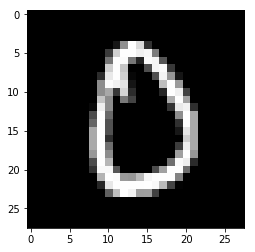

序号：53337；标签：9


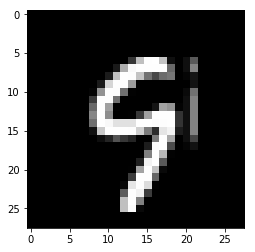

序号：32145；标签：7


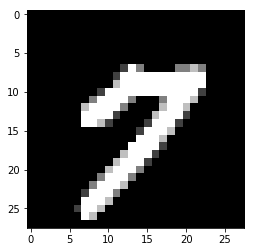

序号：28139；标签：4


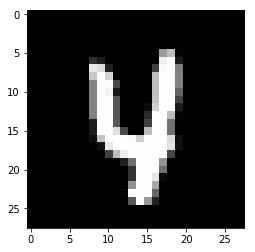

序号：42008；标签：0


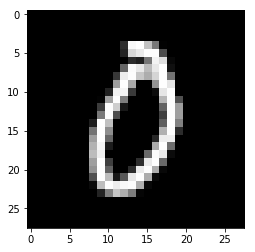

序号：55602；标签：5


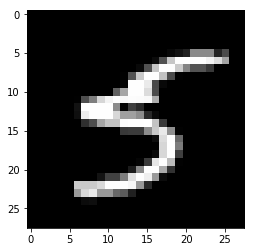

序号：15591；标签：6


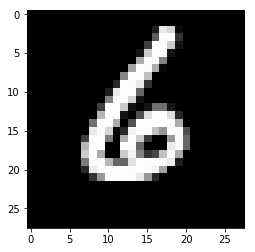

序号：47279；标签：1


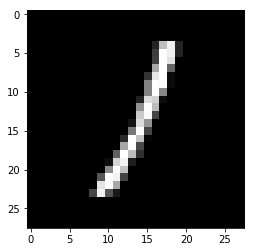

序号：17479；标签：0


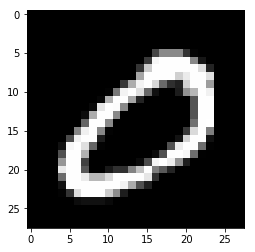

序号：10494；标签：4


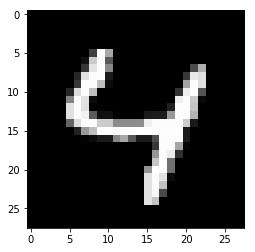

done


In [46]:
# 直接运行本模块时，执行 run()
if __name__ == '__main__':
    run()